In [1]:
# # **Loading Hive Tables and Data Preparation for Analysis**

import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.sql.functions import * 
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("Market Analysis").config(
    "spark.ui.port", "0").config(
        "spark.sql.catalogImplementation=hive").config(
        "spark.sql.warehouse.dir",
        "hdfs://nameservice1/user/itv003722/warehouse").config(
            "spark.serializer",
    "org.apache.spark.serializer.KryoSerializer").enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel('OFF')

In [3]:
MA = spark.table('bank_domain.market_analysis')

In [4]:
MA.createOrReplaceTempView('MA')

In [5]:
MA.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no| 2143.0|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|   29.0|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|    2.0|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no| 1506.0|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|    1.0|     no|  no|unknown|  5|  may

In [6]:
MA.printSchema()
MA.count()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: double (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



45211

In [7]:
#Marketing Success Rate (No. of people subscribed / total no. of entries)
spark.sql("""
 select a.subscribed,B.total, round((a.subscribed/b.total)*100,2) as success_percent from (select count(*)
as subscribed from MA where y='yes') a,(select count(*) as total from MA) b
         """).show()


+----------+-----+---------------+
|subscribed|total|success_percent|
+----------+-----+---------------+
|      5289|45211|           11.7|
+----------+-----+---------------+



In [8]:
#Marketing Failure Rate
Market_failure=spark.sql("""
 select round((a.not_subscribed/b.total)*100,2) as failure_percent from (select
count(*) as not_subscribed from MA where y='no') a,(select count(*) as total from MA) b
         """).show()

+---------------+
|failure_percent|
+---------------+
|           88.3|
+---------------+



In [9]:

#MA.select(max("age")).show()
spark.sql(
"""
select max(age) as max_age,min(age) as min_age,round(avg(age),2) as average_age from MA where y='yes'

"""
)



+-------+-------+-----------+
|max_age|min_age|average_age|
+-------+-------+-----------+
|     95|     18|      41.67|
+-------+-------+-----------+

In [10]:
#Age wise subscription to deposit
#agewise_status=spark.sql("""
#select age, count(*) as number from MA where y='yes' group by age order by age desc
#""").show()


MA.groupBy("age").agg(count(col("y")=='yes')).alias("aa").orderBy(col("age").desc()).show()

+---+----------------+
|age|count((y = yes))|
+---+----------------+
| 95|               2|
| 94|               1|
| 93|               2|
| 92|               2|
| 90|               2|
| 89|               3|
| 88|               2|
| 87|               4|
| 86|               9|
| 85|               5|
| 84|               9|
| 83|              22|
| 82|              19|
| 81|              17|
| 80|              31|
| 79|              25|
| 78|              30|
| 77|              44|
| 76|              32|
| 75|              39|
+---+----------------+
only showing top 20 rows



In [11]:
#Distinct marital Status
MA.select("marital").distinct().show()

+--------+
| marital|
+--------+
|divorced|
| married|
|  single|
+--------+



In [12]:
#Marital Category wise analysis
pandas_df = MA.select("marital", "y").groupby("marital", "y").agg(count(col("y")=="yes")).alias("subscribed_count").distinct().toPandas()

pandas_df.head()

marital    y  count((y = yes))
0  divorced  yes               622
1    single   no             10878
2    single  yes              1912
3  divorced   no              4585
4   married  yes              2755

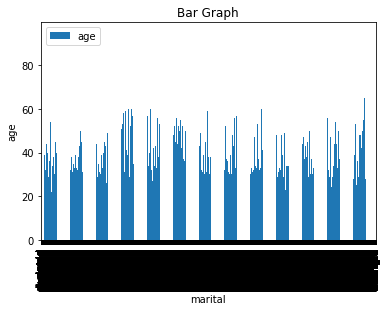

In [9]:
#Visualization of impact of marital status  
# bar graph using Pandas
pandas_df.plot(x="marital", y="age", kind="bar")
plt.xlabel("marital")
plt.ylabel("age")
plt.title("Bar Graph")
plt.show()

In [13]:
#quality of customers by checking average balance, median balance of customers
# spark.sql("""
# select  round(avg(balance)) as Average_balance,median(balance) as median_balance from MA where y='yes'
# """).show()


#Average=MA.select("balance").agg(mean("balance")).show()
quantiles = MA.filter(col("y")=='yes').approxQuantile('balance', [0.5], 0.001)
median = quantiles[0]

average = MA.filter(col("y")=='yes').agg({"balance": "mean"}).collect()[0][0]

# # Show the median and Average
print({"Median": median,"Average":average})




{'Median': 732.0, 'Average': 1804.2679145396105}


In [ ]:
#Age wise subscription to deposit
agewise_status=spark.sql("""
select age, count(*) as number from MA where y='yes' group by age order by age desc
""").show()

In [16]:
#marital status wise subscription to deposit
# MA.groupBy("marital").agg(count(col("y")=="yes")).orderBy(col("marital").desc()).toPandas().head()
Marital_status=spark.sql("""
select marital, count(*) as number from MA where y='yes' group by marital
""").show()
print("-------------------------------------------")
result = MA.groupBy("marital").agg(count(when(col("y") =='yes', col("y"))).alias("sum_value"))
#MA.groupBy('marital').agg(count(when( MA.y='yes',MA.y)).alias("sum_value"))

result.toPandas().head()


+--------+------+
| marital|number|
+--------+------+
|divorced|   622|
| married|  2755|
|  single|  1912|
+--------+------+

-------------------------------------------


marital  sum_value
0  divorced        622
1   married       2755
2    single       1912

In [17]:
#age and marital status together mattered for a subscription to deposit scheme
status=spark.sql("""
select age,marital, count(*) as number from MA where y='yes' group by age, marital order by age 
""").show()
print("----------------------------------------------")
MA.select("marital","age","y").groupBy("marital","age","y").agg(count(col("marital")=="married")).alias("a").toPandas().head(10)

+---+--------+------+
|age| marital|number|
+---+--------+------+
| 18|  single|     7|
| 19|  single|    11|
| 20|  single|    14|
| 20| married|     1|
| 21|  single|    21|
| 21| married|     1|
| 22|  single|    40|
| 23| married|     2|
| 23|  single|    42|
| 24|  single|    58|
| 24| married|    10|
| 25| married|    14|
| 25|  single|    99|
| 26|  single|   121|
| 26| married|    13|
| 27|divorced|     2|
| 27| married|    29|
| 27|  single|   110|
| 28| married|    20|
| 28|  single|   138|
+---+--------+------+
only showing top 20 rows

----------------------------------------------


marital  age    y  count((marital = married))
0    single   51  yes                           8
1   married   72  yes                          23
2   married   80   no                          18
3   married   88   no                           2
4   married   81   no                           5
5  divorced   80   no                           1
6   married   30   no                         616
7    single   49   no                          87
8    single   19  yes                          11
9  divorced   38   no                         147

In [43]:
import pandas as pd

In [19]:
#feature engineering for the bank and find the right age effect on the campaign
result = MA.withColumn(
    "Age_Category",
    when(col("age") <=20, "Teen")
    .when((col("age") >20) &( col("age") < 32) , "Young")
    .when((col("age") >=33) & (col("age") <=55), "Middle Age")
        .otherwise("old")
)
result.toPandas().head(10)

age           job   marital  education default  balance housing loan  \
0   58    management   married   tertiary      no   2143.0     yes   no   
1   44    technician    single  secondary      no     29.0     yes   no   
2   33  entrepreneur   married  secondary      no      2.0     yes  yes   
3   47   blue-collar   married    unknown      no   1506.0     yes   no   
4   33       unknown    single    unknown      no      1.0      no   no   
5   35    management   married   tertiary      no    231.0     yes   no   
6   28    management    single   tertiary      no    447.0     yes  yes   
7   42  entrepreneur  divorced   tertiary     yes      2.0     yes   no   
8   58       retired   married    primary      no    121.0     yes   no   
9   43    technician    single  secondary      no    593.0     yes   no   

   contact day month  duration  campaign  pdays  previous poutcome   y  \
0  unknown   5   may       261         1     -1         0  unknown  no   
1  unknown   5   may       151         1     -1         0  unknown  no   
2  unknown   5   may        76         1     -1         0  unknown  no   
3  unknown   5   may        92         1     -1         0  unknown  no   
4  unknown   5   may       198         1     -1         0  unknown  no   
5  unknown   5   may       139         1     -1         0  unknown  no   
6  unknown   5   may       217         1     -1         0  unknown  no   
7  unknown   5   may       380         1     -1         0  unknown  no   
8  unknown   5   may        50         1     -1         0  unknown  no   
9  unknown   5   may        55         1     -1         0  unknown  no   

  Age_Category  
0          old  
1   Middle Age  
2   Middle Age  
3   Middle Age  
4   Middle Age  
5   Middle Age  
6        Young  
7   Middle Age  
8          old  
9   Middle Age

In [6]:
result.drop("age").show()

+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+------------+
|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|Age_Category|
+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+------------+
|  management| married| tertiary|     no| 2143.0|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|         Old|
|  technician|  single|secondary|     no|   29.0|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|  Middle Age|
|entrepreneur| married|secondary|     no|    2.0|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|  Middle Age|
| blue-collar| married|  unknown|     no| 1506.0|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|  Middle Age|
|     unknown|  sing

In [ ]:
result.select("Age_Category","y").groupBy("Age_Category").agg(count(col("y"))=="yes").show()

In [ ]:
spark.sql(
"""
select  Age_Category from result where y="yes" 

"""
).show()